### Задача А: определение релевантности вопроса
В данной задаче участникам необходимо построить алгоритм, определяющий релевантность поставленных вопросов к параграфу текста. Для решения этой задачи требуется не только понимать, относится ли вопрос к параграфу, но и насколько корректно он поставлен.

Это задача бинарной классификации, в которой целевая переменная `target` принимает два значения: 0 и 1. Классу 1 соответствуют релевантные вопросы, заданные к параграфу человеком. К классу 0 относятся вопросы, либо заданные человеком к другим параграфам, либо были составлены компьютером. В качестве целевой метрики используется `ROC-AUC`.

Для решения задачи А участникам дается два файла:

1. Тренировочные 119 399 пар вопросов и параграфов `train_taskA.csv`, имеющие вид: `paragraph_id`, `question_id`, `paragraph`, `question`, `target`.
2. Тестовые 74 295 пар вопросов и параграфов `test_taskA.csv`, имеющие вид: `paragraph_id`, `question_id`, `paragraph`, `question`.

В предоставленных тренировочных и тестовых данных релевантные вопросы класса 1 были случайно выбраны из собранных вопросов и ответов. Нерелевантные примеры класса 0, составленные человеком, были получены случайным выбором вопроса к другому параграфу по той же теме. Нерелевантные вопросы класса 0, заданные компьютером, в тренировочных данных отсутствуют. Участникам необходимо самим генерировать такие вопросы для достижения лучшего качества. Также, несмотря на то, что целевая переменная target принимает два значения 0 и 1, в качестве предсказаний можно отправлять вещественные числа.

Решением задачи является `.csv` файл на основе `test_taskA.csv`, с заполненным полем `target`. Файл с решением задачи должен иметь следующий вид: `paragraph_id`, `question_id`, `target`.

[Пример решения на Python](http://nbviewer.jupyter.org/github/sberbank-ai/data-science-journey-2017/blob/master/taskA/baseline.ipynb "Ссылка на nbviewer")

[Описание метрики ROC-AUC](http://www.machinelearning.ru/wiki/index.php?title=ROC-%D0%BA%D1%80%D0%B8%D0%B2%D0%B0%D1%8F "www.machinelearning.ru")

[Материалы соревнования](https://github.com/sberbank-ai/data-science-journey-2017 "GitHub")


In [1]:
# Загрузим необходимые бибилиотеки:
library(dstools)
library(data.table)
library(tidyverse)
library(magrittr)
library(stringr)
library(tm)
library(text2vec)
library(xgboost)
library(lightgbm)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
between():   dplyr, data.table
filter():    dplyr, stats
first():     dplyr, data.table
lag():       dplyr, stats
last():      dplyr, data.table
transpose(): purrr, data.table

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

Loading required package: NLP

Attaching package: ‘NLP’

The following object is masked from ‘package:ggplot2’:

    annotate


Attaching package: ‘text2vec’

The following object is masked from ‘package:dplyr’:

    collect


Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice

Loading required package: R6

Attaching package: ‘lightgbm’

The following objects are masked from ‘

In [2]:
# Считаем данные:
train.data <- readr::read_csv('data/train_task1_latest.csv')
test.data <- readr::read_csv('data/test_task1_latest.csv')
sample.submsission <- readr::read_csv('data/sample_submission_a.csv')

Parsed with column specification:
cols(
  paragraph_id = col_integer(),
  question_id = col_integer(),
  paragraph = col_character(),
  question = col_character(),
  target = col_double()
)
Parsed with column specification:
cols(
  paragraph_id = col_integer(),
  question_id = col_integer(),
  paragraph = col_character(),
  question = col_character()
)
Parsed with column specification:
cols(
  paragraph_id = col_integer(),
  question_id = col_integer(),
  prediction = col_double()
)


In [3]:
# Взглянем на данные, чтобы проверить как они загрузились:
glimpse(train.data)
glimpse(test.data)
glimpse(sample.submsission)

Observations: 119,398
Variables: 5
$ paragraph_id <int> 1094, 7414, 6744, 7300, 7077, 3559, 4350, 8012, 3634, ...
$ question_id  <int> 46273, 19164, 39767, 36318, 41534, 62585, 3730, 86629,...
$ paragraph    <chr> "В отличие от рыб, земноводные (амфибии) и пресмыкающи...
$ question     <chr> "С какого года Русское Царство перешло на летоисчислен...
$ target       <dbl> 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, ...
Observations: 74,294
Variables: 4
$ paragraph_id <int> 1361, 1403, 1435, 341, 1317, 412, 1282, 689, 1455, 432...
$ question_id  <int> 6463, 34696, 13751, 38544, 14589, 26912, 18076, 19755,...
$ paragraph    <chr> "Передний мозг сильно развит, это самая большая часть ...
$ question     <chr> "В какой мифологии два ворона Хугин и Мунин шептали но...
Observations: 74,294
Variables: 3
$ paragraph_id <int> 1361, 1403, 1435, 341, 1317, 412, 1282, 689, 1455, 432...
$ question_id  <int> 6463, 34696, 13751, 38544, 14589, 26912, 18076, 19755,...
$ prediction   <dbl> 0.00167

In [4]:
# Баланс классов
mean(train.data$target)

[1] 0.2850718

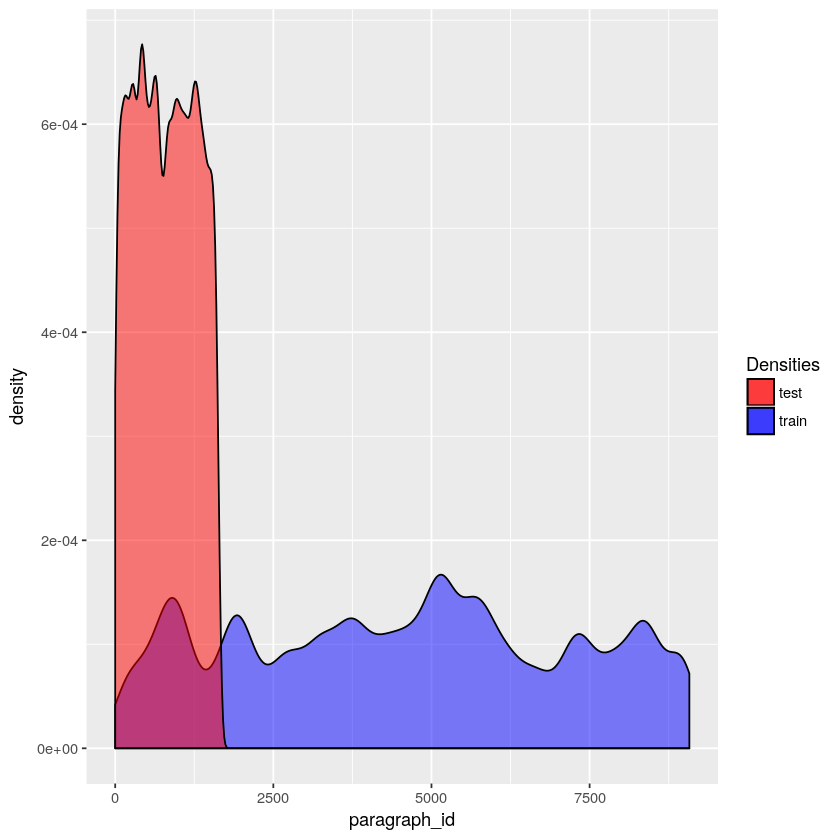

In [5]:
# Посмотрим на распределение количества вопросов в трейне и тесте по параграфам:
group.train <- train.data %>% 
  group_by(paragraph_id)
group.test <- test.data %>% 
  group_by(paragraph_id)

ggplot() +
  geom_density(data = group.train, mapping = aes(paragraph_id, fill = 'train'), alpha = 1/2) +
  geom_density(data = group.test, mapping = aes(paragraph_id, fill = 'test'), alpha = 1/2) +
  scale_fill_manual(values = c('train' = 'blue', 'test' = 'red'), name = 'Densities')

Как видим, id параграфов пересекаются в трейне и в тесте. В дальнейшем можно будет попробовать либо использовать как категориальную фичу, либо учить модель только на пересекающихся парграфах.

In [6]:
# Добавим столбцы с длиной вопроса и параграфа и посмотрим, как их отношение влияет на `target`:
train.data %<>%
  mutate(par_len = nchar(paragraph), 
         ques_len = nchar(question),
         len_ratio = ques_len / par_len)
test.data %<>%
  mutate(par_len = nchar(paragraph), 
         ques_len = nchar(question),
         len_ratio = ques_len / par_len)
train.data %>% 
  group_by(target) %>% 
  summarise(mean_ratio = mean(len_ratio))
rm(group.train, group.test)

target,mean_ratio
0,0.14707114
1,0.09187547


In [7]:
# Обрабатываем текст. Удаляем стоп-слова и цифры, приводим к нижнему регистру, делаем стемминг:
text_modify <- function(txt_, sw_ = c(), stem_ = FALSE) {
  if (length(sw_) > 0) {
    txt_ %<>% removeWords(sw_)
  }
  
  txt_ %<>% str_to_lower() %>% 
    str_replace_all('ё', 'е') %>%
    str_replace_all('-', ' ') %>% 
    str_replace_all('\\(', ' ( ') %>% 
    str_replace_all('\\)', ' ) ') %>% 
    str_replace_all('[:digit:]', ' ') %>% 
    str_replace_all("[^[:alpha:]]", " ") %>% 
    removePunctuation() %>% 
    str_replace_all("\\s+", ' ')
  
  if (stem_ == TRUE) {
    # позже разобраться с кодировкой
    # txt_ %<>%  enc2utf8() %>% 
    #   system(command = 'mystem/mystem.exe -cl',
    #          intern = TRUE,
    #          ignore.stdout = FALSE,
    #          ignore.stderr = FALSE,
    #          wait = TRUE,
    #          input = .,
    #          show.output.on.console = TRUE,
    #          minimized = FALSE,
    #          invisible = TRUE) %>% 
    #   str_replace_all('[{}]', '') %>%
    #   str_replace_all('(\\|[^ ]+)', '') %>%
    #   str_replace_all('\\?', '') %>%
    #   str_replace_all('\\s+', ' ')
    txt_ %<>%
      stemDocument('russian')
  }
  
  return(txt_)
}

sw.url <- 'https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.txt'
sw <- readr::read_csv(sw.url, col_names = F)$X1

train.data$paragraph[1] # оригинал
text_modify(train.data$paragraph[1]) # обработка
text_modify(train.data$paragraph[1], sw) # обработка и удаление стоп слов
text_modify(train.data$paragraph[1], sw, T) # обработка, удаление стоп слов и стемминг

# отмодифим текстовые данные с полной обработкой
train.data$paragraph %<>% text_modify(sw, T)
train.data$question %<>% text_modify(sw, T)
test.data$paragraph %<>% text_modify(sw, T)
test.data$question %<>% text_modify(sw, T)

Parsed with column specification:
cols(
  X1 = col_character()
)


[1] "В отличие от рыб, земноводные (амфибии) и пресмыкающиеся (рептилии или гады) уже имеют два круга кровообращения и сердце у них трёхкамерное (появляется межпредсердная перегородка). Единственные современные рептилии, имеющие хотя и неполноценное (межпредсердиевая перегородка не полностью разделяет предсердия, что скорей всего связано с переходом предков к полуводному образу жизни и снижению активности), но уже четырёхкамерное сердце — крокодилы. Считается, что впервые четырёхкамерное сердце появилось у примитивных архозавров и развитых синапсидов. В дальнейшем такое строение сердца унаследовали прямые потомки динозавров — птицы и потомки примитивных млекопитающих — современные млекопитающие."

[1] "в отличие от рыб земноводные амфибии и пресмыкающиеся рептилии или гады уже имеют два круга кровообращения и сердце у них трехкамерное появляется межпредсердная перегородка единственные современные рептилии имеющие хотя и неполноценное межпредсердиевая перегородка не полностью разделяет предсердия что скорей всего связано с переходом предков к полуводному образу жизни и снижению активности но уже четырехкамерное сердце крокодилы считается что впервые четырехкамерное сердце появилось у примитивных архозавров и развитых синапсидов в дальнейшем такое строение сердца унаследовали прямые потомки динозавров птицы и потомки примитивных млекопитающих современные млекопитающие "

[1] "в отличие рыб земноводные амфибии пресмыкающиеся рептилии гады имеют круга кровообращения сердце трехкамерное появляется межпредсердная перегородка единственные современные рептилии имеющие неполноценное межпредсердиевая перегородка полностью разделяет предсердия скорей связано переходом предков полуводному образу жизни снижению активности четырехкамерное сердце крокодилы считается впервые четырехкамерное сердце появилось примитивных архозавров развитых синапсидов в дальнейшем строение сердца унаследовали прямые потомки динозавров птицы потомки примитивных млекопитающих современные млекопитающие "

[1] "в отлич рыб земноводн амфиб пресмыка рептил гад имеют круг кровообращен сердц трехкамерн появля межпредсердн перегородк единствен современ рептил имеющ неполноцен межпредсердиев перегородк полност разделя предсерд скор связа переход предк полуводн образ жизн снижен активн четырехкамерн сердц крокодил счита вперв четырехкамерн сердц появ примитивн архозавр развит синапсид в дальн строен сердц унаследова прям потомк динозавр птиц потомк примитивн млекопита современ млекопита"

In [8]:
# Добавим фичи как поиск подстроки вопроса в параграфе, от 1 до 5 слов в группе:
subst <- function(paragraph_, question_, n = 2, ret = 'bool') {
  stopifnot(ret %in% c('bool', 'int', 'sum'))
  stopifnot(n %in% 1:5)
  if (n == 1) {
    q.split <- str_split(question_, ' ')[[1]]
    p.split <- str_split(paragraph_, ' ')[[1]]
    
  }
  if (n == 2) {
    q.split <- str_split(question_, ' ')[[1]]
    q.split <- paste(q.split, lead(q.split)) 
    p.split <- str_split(paragraph_, ' ')[[1]]
    p.split <- paste(p.split, lead(p.split)) 
  }
  if (n == 3) {
    q.split <- str_split(question_, ' ')[[1]]
    q.split <- paste(q.split, lead(q.split), lead(q.split, 2)) 
    p.split <- str_split(paragraph_, ' ')[[1]]
    p.split <- paste(p.split, lead(p.split), lead(p.split, 2)) 
  }
  if (n == 4) {
    q.split <- str_split(question_, ' ')[[1]]
    q.split <- paste(q.split, lead(q.split), lead(q.split, 2), lead(q.split, 3)) 
    p.split <- str_split(paragraph_, ' ')[[1]]
    p.split <- paste(p.split, lead(p.split), lead(p.split, 2), lead(p.split, 3)) 
  }
  if (n == 5) {
    q.split <- str_split(question_, ' ')[[1]]
    q.split <- paste(q.split, lead(q.split), lead(q.split, 2), lead(q.split, 3), lead(q.split, 4)) 
    p.split <- str_split(paragraph_, ' ')[[1]]
    p.split <- paste(p.split, lead(p.split), lead(p.split, 2), lead(p.split, 3), lead(p.split, 4)) 
  }
  
  if (ret == 'bool') return(any(q.split %in% p.split))
  if (ret == 'sum') return(sum(q.split %in% p.split))
  if (ret == 'int') return(as.integer(any(q.split %in% p.split)))
}

# количество слов в параграфе и вопросе
train.data %<>% 
  mutate(par_words = sapply(str_split(paragraph, ' '), length))
train.data %<>% 
  mutate(que_words = sapply(str_split(question, ' '), length))
test.data %<>% 
  mutate(par_words = sapply(str_split(paragraph, ' '), length))
test.data %<>% 
  mutate(que_words = sapply(str_split(question, ' '), length))

# количество пересекающихся слов
train.data$inter_words <- train.data %>% 
  select(paragraph, question) %>% 
  apply(1, function(x){
    subst(x[1], x[2], 1, 'sum')
  })
test.data$inter_words <- test.data %>% 
  select(paragraph, question) %>% 
  apply(1, function(x){
    subst(x[1], x[2], 1, 'sum')
  })

# пересекающиеся пары слов
train.data$inter2 <- train.data %>% 
  select(paragraph, question) %>% 
  apply(1, function(x){
    subst(x[1], x[2], 2, 'bool')
  })
test.data$inter2 <- test.data %>% 
  select(paragraph, question) %>% 
  apply(1, function(x){
    subst(x[1], x[2], 2, 'bool')
  })

# пересекающиеся тройки слов
train.data$inter3 <- train.data %>% 
  select(paragraph, question) %>% 
  apply(1, function(x){
    subst(x[1], x[2], 3, 'bool')
  })
test.data$inter3 <- test.data %>% 
  select(paragraph, question) %>% 
  apply(1, function(x){
    subst(x[1], x[2], 3, 'bool')
  })

# пересекающиеся четверки слов
train.data$inter4 <- train.data %>% 
  select(paragraph, question) %>% 
  apply(1, function(x){
    subst(x[1], x[2], 4, 'bool')
  })
test.data$inter4 <- test.data %>% 
  select(paragraph, question) %>% 
  apply(1, function(x){
    subst(x[1], x[2], 4, 'bool')
  })

# пересекающиеся пятерки слов
train.data$inter5 <- train.data %>% 
  select(paragraph, question) %>% 
  apply(1, function(x){
    subst(x[1], x[2], 5, 'bool')
  })
test.data$inter5 <- test.data %>% 
  select(paragraph, question) %>% 
  apply(1, function(x){
    subst(x[1], x[2], 5, 'bool')
  })

In [9]:
# Добавим как фичи расстояния и похожесть, подсчитанные разными методами:
# train
it.paragraph <- itoken(train.data$paragraph, progressbar = FALSE)
it.question <- itoken(train.data$question, progressbar = FALSE)

it <- itoken(c(train.data$paragraph, train.data$question), progressbar = FALSE)
v <- create_vocabulary(it) %>% prune_vocabulary(doc_proportion_max = 0.1, term_count_min = 5)
vectorizer <- vocab_vectorizer(v)

dtm.paragraph <- create_dtm(it.paragraph, vectorizer)
dtm.question <- create_dtm(it.question, vectorizer)

train.data$jac_sim <- psim2(dtm.paragraph, dtm.question, method = 'jaccard', norm = 'none')
train.data$cos_sim <- psim2(dtm.paragraph, dtm.question, method = 'cosine', norm = 'none')
#train.data$jac_dist <- pdist2(dtm.paragraph, dtm.question, method = 'jaccard', norm = 'none')
#train.data$cos_dist <- pdist2(dtm.paragraph, dtm.question, method = 'cosine', norm = 'none')

tfidf <- TfIdf$new()
dtm.tfidf.par <- fit_transform(dtm.paragraph, tfidf)
tfidf <- TfIdf$new()
dtm.tfidf.que <- fit_transform(dtm.question, tfidf)
train.data$tfidf_sim <- psim2(dtm.tfidf.par, dtm.tfidf.que, method = 'cosine', norm = 'none')

# lsa <- LSA$new(n_topics = 100)
# dtm.tfidf.par.lsa <- fit_transform(dtm.tfidf.par, lsa)
# lsa <- LSA$new(n_topics = 100)
# dtm.tfidf.que.lsa <- fit_transform(dtm.tfidf.que, lsa)
# train.data$tfidf_lsa_sim <- psim2(dtm.tfidf.par.lsa, dtm.tfidf.que.lsa, method = 'cosine', norm = 'none')

# test
it.paragraph <- itoken(test.data$paragraph, progressbar = FALSE)
it.question <- itoken(test.data$question, progressbar = FALSE)

it <- itoken(c(test.data$paragraph, test.data$question), progressbar = FALSE)
v <- create_vocabulary(it) %>% prune_vocabulary(doc_proportion_max = 0.1, term_count_min = 5)
vectorizer <- vocab_vectorizer(v)

dtm.paragraph <- create_dtm(it.paragraph, vectorizer)
dtm.question <- create_dtm(it.question, vectorizer)

test.data$jac_sim <- psim2(dtm.paragraph, dtm.question, method = 'jaccard', norm = 'none')
test.data$cos_sim <- psim2(dtm.paragraph, dtm.question, method = 'cosine', norm = 'none')
#test.data$jac_dist <- pdist2(dtm.paragraph, dtm.question, method = 'jaccard', norm = 'none')
#test.data$cos_dist <- pdist2(dtm.paragraph, dtm.question, method = 'cosine', norm = 'none')

tfidf <- TfIdf$new()
dtm.tfidf.par <- fit_transform(dtm.paragraph, tfidf)
tfidf <- TfIdf$new()
dtm.tfidf.que <- fit_transform(dtm.question, tfidf)
test.data$tfidf_sim <- psim2(dtm.tfidf.par, dtm.tfidf.que, method = 'cosine', norm = 'none')

# lsa <- LSA$new(n_topics = 100)
# dtm.tfidf.par.lsa <- fit_transform(dtm.tfidf.par, lsa)
# lsa <- LSA$new(n_topics = 100)
# dtm.tfidf.que.lsa <- fit_transform(dtm.tfidf.que, lsa)
# test.data$tfidf_lsa_sim <- psim2(dtm.tfidf.par.lsa, dtm.tfidf.que.lsa, method = 'cosine', norm = 'none')

rm(v, dtm.paragraph, dtm.question, it, it.paragraph, it.question, sw, sw.url, text_modify, vectorizer,
   tfidf, dtm.tfidf.par, dtm.tfidf.que, lsa, dtm.tfidf.par.lsa, dtm.tfidf.que.lsa, subst)
gc()

readr::write_rds(train.data, 'data/train.rds')
readr::write_rds(test.data, 'data/test.rds')

Warning message in rm(v, dtm.paragraph, dtm.question, it, it.paragraph, it.question, :
“объект 'lsa' не найден”Warning message in rm(v, dtm.paragraph, dtm.question, it, it.paragraph, it.question, :
“объект 'dtm.tfidf.par.lsa' не найден”Warning message in rm(v, dtm.paragraph, dtm.question, it, it.paragraph, it.question, :
“объект 'dtm.tfidf.que.lsa' не найден”

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,1665577,89.0,3205452,171.2,3205452,171.2
Vcells,11880250,90.7,53411905,407.6,66764881,509.4


### загрузим rds и обучим модели

In [10]:
# загрузим данные
train.data <- readr::read_rds('data/train.rds')
test.data <- readr::read_rds('data/test.rds')

In [11]:
# Подготовим данные для построения модели:
#1
X1 <- rbind(filter(train.data, target == 1), 
            sample_n(filter(train.data, target == 0), 
                     nrow(filter(train.data, target == 1))))
X1 <- X1[sample(nrow(X1)),]
y1 <- X1$target
X1 <- X1 %>% 
    select(-question_id, -paragraph, -question, -target)
X1$paragraph_id <- as.factor(X1$paragraph_id)
X1 <- ds_toSparseMatrix(X1)

#2
X2 <- rbind(filter(train.data, target == 1), 
            sample_n(filter(train.data, target == 0), 
                     nrow(filter(train.data, target == 1))))
X2 <- X2[sample(nrow(X2)),]
y2 <- X2$target
X2 <- X2 %>% 
    select(-question_id, -paragraph, -question, -target)
X2$paragraph_id <- as.factor(X2$paragraph_id)
X2 <- ds_toSparseMatrix(X2)

#3
X3 <- rbind(filter(train.data, target == 1), 
            sample_n(filter(train.data, target == 0), 
                     nrow(filter(train.data, target == 1))))
X3 <- X3[sample(nrow(X3)),]
y3 <- X3$target
X3 <- X3 %>% 
    select(-question_id, -paragraph, -question, -target)
X3$paragraph_id <- as.factor(X3$paragraph_id)
X3 <- ds_toSparseMatrix(X3)


X_pred <- test.data %>% 
  select(-question_id, -paragraph, -question)
X_pred$paragraph_id <- as.factor(X_pred$paragraph_id)
X_pred <- ds_toSparseMatrix(X_pred)


Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand



In [12]:
# обучим 3 модели и усредним
# xgboost
k <- 4 
param <- list(
  eta = 0.2/k,
  nround = 550*k,
  max_depth = 5,
  colsample_bytree = 1,
  subsample = 1,
  min_child_weight = 1,
  gamma = 0,
  #scale_pos_weight = 2.5,
  tree_method = 'auto',
  eval_metric = 'auc',
  objective = 'binary:logistic'
)

model1 <- xgboost(
  data = X1,
  label = y1,
  params = param,
  boosting = 'dart',
  nrounds = param$nround,
  print_every_n = 100,
  early_stopping_rounds = 100
)

model2 <- xgboost(
  data = X2,
  label = y2,
  params = param,
  boosting = 'dart',
  nrounds = param$nround,
  print_every_n = 100,
  early_stopping_rounds = 100
)

model3 <- xgboost(
  data = X3,
  label = y3,
  params = param,
  boosting = 'dart',
  nrounds = param$nround,
  print_every_n = 100,
  early_stopping_rounds = 100
)

res <- tibble(p1 = predict(model1, X_pred),
              p2 = predict(model2, X_pred),
              p3 = predict(model3, X_pred))
sample.submsission$prediction <- rowMeans(res)
readr::write_csv(sample.submsission, 'data/xgb_bl.csv')

[1]	train-auc:0.985553 
Will train until train_auc hasn't improved in 100 rounds.

[101]	train-auc:0.995612 
[201]	train-auc:0.996310 
[301]	train-auc:0.996557 
[401]	train-auc:0.996729 
[501]	train-auc:0.996873 
[601]	train-auc:0.996979 
[701]	train-auc:0.997070 
[801]	train-auc:0.997135 
[901]	train-auc:0.997214 
[1001]	train-auc:0.997274 
[1101]	train-auc:0.997339 
[1201]	train-auc:0.997401 
[1301]	train-auc:0.997454 
[1401]	train-auc:0.997501 
[1501]	train-auc:0.997553 
[1601]	train-auc:0.997660 
[1701]	train-auc:0.997741 
[1801]	train-auc:0.997796 
[1901]	train-auc:0.997839 
[2001]	train-auc:0.997899 
[2101]	train-auc:0.997961 
[2200]	train-auc:0.998012 
[1]	train-auc:0.986429 
Will train until train_auc hasn't improved in 100 rounds.

[101]	train-auc:0.995806 
[201]	train-auc:0.996536 
[301]	train-auc:0.996790 
[401]	train-auc:0.996968 
[501]	train-auc:0.997102 
[601]	train-auc:0.997200 
[701]	train-auc:0.997295 
[801]	train-auc:0.997365 
[901]	train-auc:0.997435 
[1001]	train-au

In [13]:
# обучим 3 модели и усредним
# lightgbm
k <- 2
param <- list(learning_rate = 0.2/k,
              num_tree = 550*k, 
              max_depth = 5, 
              num_leaves = 1024,
              max_bin = 256,
              lambda_l1 = 3,
              lambda_l2 = 5,
              feature_fraction = 1, 
              bagging_fraction = 1, 
              bagging_freq = 6, 
              #scale_pos_weight = 2.5, 
              metric = 'auc',
              objective = 'binary')

lgb.unloader(wipe = T)
model1 <- lightgbm(data = X1,
                  label = y1,
                  params = param,
                  boosting = 'dart',
                  nrounds = param$num_tree,
                  early_stopping_rounds = 50,
                  verbose = 1L)

lgb.unloader(wipe = T)
model2 <- lightgbm(data = X2,
                  label = y2,
                  params = param,
                  boosting = 'dart',
                  nrounds = param$num_tree,
                  early_stopping_rounds = 50,
                  verbose = 1L)

lgb.unloader(wipe = T)
model3 <- lightgbm(data = X3,
                  label = y3,
                  params = param,
                  boosting = 'dart',
                  nrounds = param$num_tree,
                  early_stopping_rounds = 50,
                  verbose = 1L)

res <- tibble(p1 = predict(model1, X_pred),
              p2 = predict(model2, X_pred),
              p3 = predict(model3, X_pred))
sample.submsission$prediction <- rowMeans(res)
readr::write_csv(sample.submsission, 'data/lgb_bl.csv')


Attaching package: ‘lightgbm’

The following objects are masked from ‘package:xgboost’:

    getinfo, setinfo, slice

The following object is masked from ‘package:dplyr’:

    slice



[1]:	train's auc:0.984944 
[2]:	train's auc:0.986767 
[3]:	train's auc:0.987915 
[4]:	train's auc:0.988328 
[5]:	train's auc:0.988293 
[6]:	train's auc:0.988572 
[7]:	train's auc:0.98957 
[8]:	train's auc:0.989576 
[9]:	train's auc:0.98996 
[10]:	train's auc:0.990093 
[11]:	train's auc:0.990199 
[12]:	train's auc:0.990321 
[13]:	train's auc:0.990339 
[14]:	train's auc:0.990567 
[15]:	train's auc:0.990775 
[16]:	train's auc:0.990783 
[17]:	train's auc:0.991084 
[18]:	train's auc:0.991401 
[19]:	train's auc:0.991413 
[20]:	train's auc:0.991445 
[21]:	train's auc:0.991506 
[22]:	train's auc:0.991657 
[23]:	train's auc:0.991682 
[24]:	train's auc:0.99171 
[25]:	train's auc:0.991908 
[26]:	train's auc:0.992059 
[27]:	train's auc:0.992418 
[28]:	train's auc:0.992423 
[29]:	train's auc:0.992514 
[30]:	train's auc:0.99274 
[31]:	train's auc:0.992806 
[32]:	train's auc:0.992936 
[33]:	train's auc:0.993082 
[34]:	train's auc:0.993316 
[35]:	train's auc:0.993351 
[36]:	train's auc:0.993418 
[37]:


Attaching package: ‘lightgbm’

The following objects are masked from ‘package:xgboost’:

    getinfo, setinfo, slice

The following object is masked from ‘package:dplyr’:

    slice



[1]:	train's auc:0.983386 
[2]:	train's auc:0.98666 
[3]:	train's auc:0.987569 
[4]:	train's auc:0.987764 
[5]:	train's auc:0.988212 
[6]:	train's auc:0.988944 
[7]:	train's auc:0.989713 
[8]:	train's auc:0.989777 
[9]:	train's auc:0.989958 
[10]:	train's auc:0.990081 
[11]:	train's auc:0.990283 
[12]:	train's auc:0.990251 
[13]:	train's auc:0.990905 
[14]:	train's auc:0.990931 
[15]:	train's auc:0.99151 
[16]:	train's auc:0.991546 
[17]:	train's auc:0.991736 
[18]:	train's auc:0.991863 
[19]:	train's auc:0.991897 
[20]:	train's auc:0.992018 
[21]:	train's auc:0.992021 
[22]:	train's auc:0.992094 
[23]:	train's auc:0.992276 
[24]:	train's auc:0.992432 
[25]:	train's auc:0.992646 
[26]:	train's auc:0.992772 
[27]:	train's auc:0.992921 
[28]:	train's auc:0.992906 
[29]:	train's auc:0.992966 
[30]:	train's auc:0.993211 
[31]:	train's auc:0.993276 
[32]:	train's auc:0.993513 
[33]:	train's auc:0.993569 
[34]:	train's auc:0.993702 
[35]:	train's auc:0.993702 
[36]:	train's auc:0.993717 
[37


Attaching package: ‘lightgbm’

The following objects are masked from ‘package:xgboost’:

    getinfo, setinfo, slice

The following object is masked from ‘package:dplyr’:

    slice



[1]:	train's auc:0.985433 
[2]:	train's auc:0.987287 
[3]:	train's auc:0.987628 
[4]:	train's auc:0.987998 
[5]:	train's auc:0.98852 
[6]:	train's auc:0.988702 
[7]:	train's auc:0.989264 
[8]:	train's auc:0.989714 
[9]:	train's auc:0.989843 
[10]:	train's auc:0.989886 
[11]:	train's auc:0.990176 
[12]:	train's auc:0.990168 
[13]:	train's auc:0.990446 
[14]:	train's auc:0.990556 
[15]:	train's auc:0.990879 
[16]:	train's auc:0.991038 
[17]:	train's auc:0.991191 
[18]:	train's auc:0.991243 
[19]:	train's auc:0.991651 
[20]:	train's auc:0.991671 
[21]:	train's auc:0.991678 
[22]:	train's auc:0.991789 
[23]:	train's auc:0.991842 
[24]:	train's auc:0.992203 
[25]:	train's auc:0.992343 
[26]:	train's auc:0.992458 
[27]:	train's auc:0.992581 
[28]:	train's auc:0.992597 
[29]:	train's auc:0.992698 
[30]:	train's auc:0.992774 
[31]:	train's auc:0.992901 
[32]:	train's auc:0.993057 
[33]:	train's auc:0.993154 
[34]:	train's auc:0.99331 
[35]:	train's auc:0.993314 
[36]:	train's auc:0.993317 
[37

ERROR: Error in predict(model1, X_pred): объект 'model1' не найден
